In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
import ktrain
from ktrain import graph as gr

Using TensorFlow backend.


using Keras version: 2.2.4


# Node Classification in Graphs


In this notebook, we will use *ktrain* to perform node classificaiton on the PubMed Diabetes citation graph.  In the PubMed graph, each node represents a paper pertaining to one of three topics:  *Diabetes Mellitus - Experimental*, *Diabetes Mellitus - Type 1*, and *Diabetes Mellitus - Type 2*.  Links represent citations between papers.  The attributes or features assigned to each node is a vector of words in each paper and their corresponding TF-IDF scores.

### STEP 1: Load and Preprocess Data

In [3]:
DATADIR = 'data/pubmed/Pubmed-Diabetes/data'
(train_data, val_data, preproc, 
 df_holdout, G_complete)        = gr.graph_nodes_from_csv(DATADIR+'/pubmed-nodes.tab',
                                           DATADIR+'/pubmed-edges.tab',
                                           sample_size=10, holdout_pct=0.2,
                                           train_pct=0.05, sep='\t')

Largest subgraph statistics: 19717 nodes, 44327 edges
Size of training graph: 15774 nodes
Labeled nodes in training graph: 788 (training)
Unlabeled nodes in training graph: 14986 (validation)

3943 additional nodes held out for testing
Size of graph with added holdout nodes: 19717


### STEP 2: Build a Model and Wrap in Learner Object

In [4]:
gr.print_node_classifiers()

graphsage: GraphSAGE:  http://arxiv.org/pdf/1607.01759.pdf


In [5]:
learner = ktrain.get_learner(model=gr.graph_node_classifier('graphsage', train_data), 
                             train_data=train_data, 
                             val_data=val_data, 
                             batch_size=64)

Is Multi-Label? False
done


### STEP 3:  Estimate LR 
Given the small number of batches per epoch, a larger number of epochs is required to estimate the learning rate. We will cap it at 100 here.

In [6]:
learner.lr_find(max_epochs=100)

simulating training for different learning rates... this may take a few moments...
Epoch 1/100
12/12 [==============================] - 1s 86ms/step - loss: 1.1014 - acc: 0.3757
Epoch 2/100
12/12 [==============================] - 0s 37ms/step - loss: 1.1053 - acc: 0.3639
Epoch 3/100
12/12 [==============================] - 0s 31ms/step - loss: 1.0938 - acc: 0.4110
Epoch 4/100
12/12 [==============================] - 0s 33ms/step - loss: 1.0994 - acc: 0.3953
Epoch 5/100
12/12 [==============================] - 0s 29ms/step - loss: 1.1090 - acc: 0.3744
Epoch 6/100
12/12 [==============================] - 0s 31ms/step - loss: 1.1032 - acc: 0.3782
Epoch 7/100
12/12 [==============================] - 0s 32ms/step - loss: 1.1096 - acc: 0.3756
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 1.0985 - acc: 0.3581
Epoch 9/100
12/12 [==============================] - 0s 33ms/step - loss: 1.1027 - acc: 0.3718
Epoch 10/100
12/12 [==============================] - 0s 30ms/

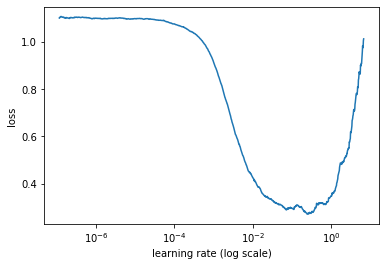

In [7]:
learner.lr_plot()

### STEP 4: Train the Model
We will train the model using `autofit`, which uses a triangular learning rate policy.  The training will automatically stop when the validation accuracy no longer improves.

In [8]:
learner.autofit(0.005, monitor='val_acc')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.005...
Epoch 1/1024
13/13 [==============================] - 6s 459ms/step - loss: 1.0654 - acc: 0.4118 - val_loss: 0.9983 - val_acc: 0.4909
Epoch 2/1024
13/13 [==============================] - 6s 469ms/step - loss: 0.9724 - acc: 0.5556 - val_loss: 0.8695 - val_acc: 0.6400
Epoch 3/1024
13/13 [==============================] - 6s 475ms/step - loss: 0.8471 - acc: 0.7029 - val_loss: 0.7337 - val_acc: 0.7494
Epoch 4/1024
13/13 [==============================] - 6s 481ms/step - loss: 0.7332 - acc: 0.7728 - val_loss: 0.6309 - val_acc: 0.7821
Epoch 5/1024
13/13 [==============================] - 6s 479ms/step - loss: 0.6164 - acc: 0.8031 - val_loss: 0.5784 - val_acc: 0.7881
Epoch 6/1024
13/13 [==============================] - 6s 453ms/step - loss: 0.5460 - acc: 0.8357 - val_loss: 0.5538 - val_acc: 0.7910
Epoch 7/1024

## Evaluate

#### Validate

In [10]:
learner.validate(class_names=preproc.get_classes())

                                precision    recall  f1-score   support

Diabetes_Mellitus-Experimental       0.77      0.82      0.80      3122
      Diabetes_Mellitus_Type_1       0.83      0.79      0.81      5967
      Diabetes_Mellitus_Type_2       0.84      0.85      0.84      5897

                      accuracy                           0.82     14986
                     macro avg       0.81      0.82      0.81     14986
                  weighted avg       0.82      0.82      0.82     14986



array([[2561,  395,  166],
       [ 449, 4703,  815],
       [ 308,  595, 4994]])

#### Create a Predictor Object

In [11]:
p = ktrain.get_predictor(learner.model, preproc)

#### Transductive Inference:  Making Predictions for Unlabeled Nodes in Original Training Graph
In transductive inference, we make predictions for unlabeled nodes whose features are visible during training. Making predictions on validation nodes in the training graph is transductive inference.

Let's see how well our prediction is for the first validation example.

In [12]:
p.predict_transductive(val_data.ids[0:1], return_proba=True)

array([[0.02923679, 0.13542812, 0.8353351 ]], dtype=float32)

In [13]:
val_data[0][1][0]

array([0., 0., 1.])

Let's make predictions for all validation nodes and visually compare some of them with ground truth.

In [14]:
y_pred = p.predict_transductive(val_data.ids, return_proba=False)

In [15]:
y_true = preproc.df[preproc.df.index.isin(val_data.ids)]['target'].values

In [16]:
import pandas as pd
pd.DataFrame(zip(y_true, y_pred), columns=['Ground Truth', 'Predicted']).head()

,Ground Truth,Predicted
0,Diabetes_Mellitus_Type_2,Diabetes_Mellitus_Type_2
1,Diabetes_Mellitus_Type_1,Diabetes_Mellitus_Type_1
2,Diabetes_Mellitus_Type_2,Diabetes_Mellitus_Type_2
3,Diabetes_Mellitus_Type_2,Diabetes_Mellitus_Type_2
4,Diabetes_Mellitus-Experimental,Diabetes_Mellitus-Experimental


#### Inductive Inference:  Making Predictions for New Nodes Not in the Original Training Graph
In inductive inference, we make predictions for entirely new nodes that were not present in the traning graph.  The features or attributes of these nodes were **not** visible during training.  We consider a graph where the heldout nodes are added back into the training graph, which yields the original graph of 19,7171 nodes. This graph, `G_complete` was returned as the last return value of `graph_nodes_from_csv`.

In [17]:
y_pred = p.predict_inductive(df_holdout, G_complete, return_proba=False)

In [18]:
y_true = df_holdout['target'].values

In [20]:
import numpy as np
(y_true == np.array(y_pred)).mean()

0.8260207963479584

With an **82.26%** accuracy, we see that inductive performance is quite good and comparable to transductive performance.